<h1>Machine Learning approach to achieve efficient DMFT solution<h1>

<p>We use DMFT with exact diagonalization (ED) as impurity solver<p> 
<p>ED solver require intinsic parameter called bath orbital obtain using optization fit to bath funtion<p>

$$\mathcal{G}^0(i\omega_n) = -i\omega_n+T +\sum_i\frac{V_i}{i\omega_n+\epsilon_i}$$ 
    
    
    
<p>where 'i' is the number of bath orbital<p>

In [1]:
#----Initialization----------------------
import numpy as np
import pandas as pd
import tensorflow
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.special import softmax
from scipy import sparse
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import math
pi=math.pi
exp=math.exp


<p> Idea is to get the green's funtion for low number of orbital and train a model with an output with 8 obital<p>
 <p> $$i\omega_n=256$$, $$U=0-12 (500)$$ (normal distribution) and $$N_b=2,3,6$$<p>

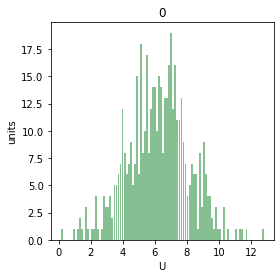

In [2]:
inp_up=np.loadtxt('Gfupin.dat') # input with 2,4,6 orbital 100 random U
inp_dw=np.loadtxt('Gfdwin.dat')
out_up=np.loadtxt('Gfupout.dat') # output with 8 orbital 100
out_dw=np.loadtxt('Gfdwout.dat')
#------------------To cross check we reshape-------------
Ginp_up=np.reshape(inp_up, (500,256*3), order='C')
Ginp_dw=np.reshape(inp_dw, (500,256*3),order='C')
Gout_up=np.reshape(out_up, (500,256),order='C')
Gout_dw=np.reshape(out_dw, (500,256),order='C')

tmp=np.reshape(Ginp_up,(500,256,3))
tmpdw=np.reshape(Ginp_dw,(500,256,3))


interaction=np.loadtxt('../U.dat')
dfint=pd.DataFrame(data=interaction)
dfint.hist(bins=100, grid=False, figsize=(4,4), color='#86bf91', zorder=2, rwidth=0.9)
plt.xlabel('U')
plt.ylabel("units")
plt.show()

In [3]:
xdata=np.arange(0,256)
#wn=((2*np.arange(0,256)+1)*pi)/50
wn=xdata

In [4]:
from scipy.optimize import curve_fit
def func(x, a, b, c, d, e):
    return a*np.exp(-b*x) +c*np.exp(-d*(256-x))+e

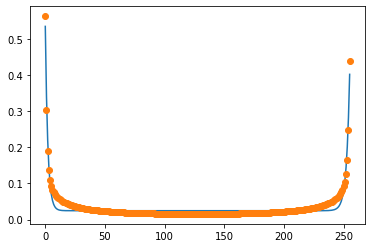

In [5]:
popt_f=[]
for i in range(500):
    ydata=tmp[i,:,0]
    guess=[1.0,1.0,1.0,1.0,0.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2],popt[3],popt[4]])

d2orb=pd.DataFrame(popt_f)   
d2orb.columns=['param02','param12','param22','param32','param42']
#y_new=func(wn, popt[0], popt[1], popt[2], popt[3], popt[4])

index=d2orb.iloc[6].to_numpy()
y_new=func(wn, index[0], index[1], index[2], index[3],index[4])
plt.plot(wn, y_new)
plt.plot(wn, tmp[6,:,0],'o')

In [6]:
popt_f=[]
for i in range(500):
    ydata=tmp[i,:,1]
    guess=[1.0,1.0,1.0,1.0,0.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2],popt[3],popt[4]])

d4orb=pd.DataFrame(popt_f)
d4orb.columns=['param04','param14','param24','param34','param44']
d4orb

,param04,param14,param24,param34,param44
0,0.073760,0.675941,1.718961,0.632562,0.000369
1,0.432067,0.186079,0.487670,0.219625,0.025127
2,0.072279,0.682703,1.736551,0.640697,0.000361
3,0.928892,0.708694,0.128252,0.735573,0.000297
4,0.141408,0.498823,1.222956,0.394248,0.000800
...,...,...,...,...,...
495,0.086882,0.626723,1.581090,0.567772,0.000446
496,0.862425,0.472025,0.196297,0.554875,0.000605
497,0.811058,0.371749,0.245494,0.482565,0.000878
498,0.927633,0.701808,0.129646,0.730491,0.000302


In [7]:
popt_f=[]
for i in range(500):
    ydata=tmp[i,:,2]
    guess=[1.0,1.0,1.0,1.0,0.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2],popt[3],popt[4]])

d6orb=pd.DataFrame(popt_f)
d6orb.columns=['param06','param16','param26','param36','param46']
d6orb

,param06,param16,param26,param36,param46
0,0.913133,0.632263,0.144944,0.675634,0.000370
1,0.713919,0.253224,0.329440,0.394122,0.001672
2,0.915024,0.640498,0.142852,0.681181,0.000363
3,0.928788,0.708454,0.128404,0.735321,0.000299
4,0.824049,0.393637,0.233135,0.498035,0.000804
...,...,...,...,...,...
495,0.895982,0.567335,0.162439,0.624844,0.000450
496,0.862092,0.471446,0.196585,0.554658,0.000608
497,0.810581,0.371094,0.245839,0.482086,0.000883
498,0.927529,0.701530,0.129554,0.728681,0.000305


In [8]:
popt_f=[]
for i in range(500):
    ydata=Gout_up[i,:]
    guess=[1.0,1.0,1.0,1.0,0.0]
    popt, pcov = curve_fit(func, wn, ydata, p0=guess)
    popt_f.append([popt[0],popt[1],popt[2],popt[3],popt[4]])

d8orb=pd.DataFrame(popt_f)
d8orb.columns=['param08','param18','param28','param38','param48']

In [9]:
Gin = pd.concat([d2orb, d4orb,d6orb], axis=1)
Gin

,param02,param12,param22,param32,param42,param04,param14,param24,param34,param44,param06,param16,param26,param36,param46
0,0.517327,0.499995,0.556953,0.394886,0.023916,0.073760,0.675941,1.718961,0.632562,0.000369,0.913133,0.632263,0.144944,0.675634,0.000370
1,0.405867,0.137141,0.530607,0.279859,0.023350,0.432067,0.186079,0.487670,0.219625,0.025127,0.713919,0.253224,0.329440,0.394122,0.001672
2,0.073137,0.680090,1.725304,0.635380,0.000341,0.072279,0.682703,1.736551,0.640697,0.000361,0.915024,0.640498,0.142852,0.681181,0.000363
3,0.366557,0.427472,0.930290,0.546821,0.022527,0.928892,0.708694,0.128252,0.735573,0.000297,0.928788,0.708454,0.128404,0.735321,0.000299
4,0.145586,0.493649,1.201650,0.384284,0.000799,0.141408,0.498823,1.222956,0.394248,0.000800,0.824049,0.393637,0.233135,0.498035,0.000804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.498897,0.448115,0.540933,0.355915,0.025022,0.086882,0.626723,1.581090,0.567772,0.000446,0.895982,0.567335,0.162439,0.624844,0.000450
496,0.115206,0.551381,1.365710,0.463849,0.000588,0.862425,0.472025,0.196297,0.554875,0.000605,0.862092,0.471446,0.196585,0.554658,0.000608
497,0.803756,0.361136,0.251899,0.477082,0.000883,0.811058,0.371749,0.245494,0.482565,0.000878,0.810581,0.371094,0.245839,0.482086,0.000883
498,0.367519,0.425368,0.923998,0.543423,0.022653,0.927633,0.701808,0.129646,0.730491,0.000302,0.927529,0.701530,0.129554,0.728681,0.000305


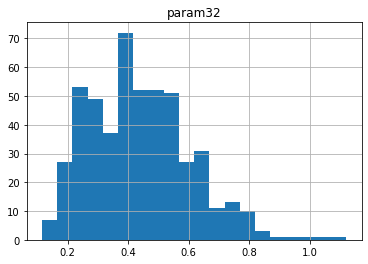

In [10]:
Gin.hist(column='param32',bins=20)

plt.show()

In [11]:
Gin['param12'].max()

1.1624397637653563

In [12]:
Xin=Gin.to_numpy()
Xin.shape

(500, 15)

In [13]:
Xout=d8orb.to_numpy()
Xout.shape

(500, 5)

array([[<AxesSubplot:title={'center':'param18'}>]], dtype=object)

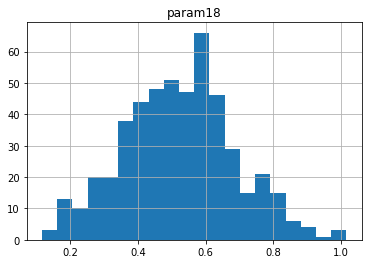

In [14]:
d8orb.hist(column='param18',bins=20)

In [31]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# fit model
regr=model.fit(Gin, d8orb)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 [ 1.45255755 -0.22902453 -2.83911755 -0.41695939  0.00453453]
Coefficients: 
 [[-3.31413569e-01  8.79231352e-02 -2.21570228e-01  5.06898501e-01
  -2.63051500e-01 -1.10394443e+00 -6.08450079e-01 -5.90351336e-01
   1.75102589e+00 -4.45662600e+00 -1.76363907e-01 -6.88630781e-01
  -3.99493179e-02  7.12392111e-02  1.16263208e+00]
 [ 1.43129255e-01 -1.11720350e-02  8.51473294e-02 -9.35023683e-02
   4.17621771e-01  8.64880070e-02  4.56418534e-01  3.60461933e-02
   7.20260061e-02  2.66433035e+00  1.32550459e-01  3.04451967e-01
   6.50265769e-02  6.98204965e-02 -2.83967231e+00]
 [ 9.38503864e-01 -4.17703570e-01  6.02988917e-01 -1.20689604e+00
  -1.17583970e+00  3.55564537e+00  1.98255651e+00  1.82822591e+00
  -4.78395819e+00  9.10867714e+00  7.52773883e-01  2.01904707e+00
   2.82793284e-01  4.66768174e-02 -4.51534665e+00]
 [ 1.48218307e-01 -5.10340426e-02  8.52381189e-02 -7.57607733e-02
  -1.83801086e-01  3.03292102e-01  5.27956937e-01  1.36583014e-01
  -2.13526736e-02  1.57976396e

In [44]:
X_train, X_test, y_train, y_test = train_test_split(Gin, d8orb, test_size=0.2, random_state=0)
X_test.shape

(100, 15)

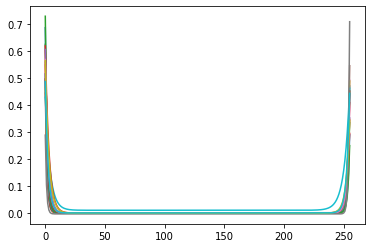

In [47]:
y_pred = regr.predict(X_test)
index=y_pred
index
for i in range(20):
    y_new=func(wn, index[i,0], index[i,1], index[i,2], index[i,3],index[i,4])
    plt.plot(wn, y_new)
#index[0,1]

In [67]:

X_train, X_test, y_train, y_test = train_test_split(Xin, Xout, test_size=0.2)
yhat = model.predict(X_test)
yhat.shape

(100, 5)

In [71]:
from keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l2

values = [1e-4]
all_train, all_test = list(), list()
for params in values:
    model = Sequential()
    #model.add(Dense(5, activation = 'relu',input_shape=(15,),kernel_regularizer = l2(l = params)))
    model.add(Dense(20, activation = 'relu',kernel_initializer='he_normal',input_shape=(15,)))
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation = 'relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(20, activation = 'relu',kernel_initializer='he_uniform'))
    model.add(Dense(10, activation = 'relu',kernel_initializer='he_uniform'))
    model.add(Dense(10, activation = 'relu',kernel_initializer='he_uniform'))
    #model.add(Dropout(0.2))
    model.add(Dense(5))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
    history = model.fit(X_train, y_train, batch_size=10, epochs = 500, verbose = 1, validation_data=(X_test,y_test))
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (params, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)                  

Epoch 1/500
40/40 [==============================] - 1s 6ms/step - loss: 0.4502 - accuracy: 0.0300 - val_loss: 0.3818 - val_accuracy: 0.1000
Epoch 2/500
40/40 [==============================] - 0s 2ms/step - loss: 0.3052 - accuracy: 0.1525 - val_loss: 0.3096 - val_accuracy: 0.1200
Epoch 3/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2078 - accuracy: 0.2975 - val_loss: 0.1901 - val_accuracy: 0.4000
Epoch 4/500
40/40 [==============================] - 0s 2ms/step - loss: 0.1362 - accuracy: 0.4425 - val_loss: 0.1450 - val_accuracy: 0.4200
Epoch 5/500
40/40 [==============================] - 0s 2ms/step - loss: 0.1155 - accuracy: 0.4575 - val_loss: 0.1353 - val_accuracy: 0.4200
Epoch 6/500
40/40 [==============================] - 0s 3ms/step - loss: 0.1109 - accuracy: 0.4575 - val_loss: 0.1350 - val_accuracy: 0.4200
Epoch 7/500
40/40 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.4575 - val_loss: 0.1308 - val_accuracy: 0.4200
Epoch 8/500
4

Epoch 59/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0995 - accuracy: 0.4775 - val_loss: 0.1262 - val_accuracy: 0.4100
Epoch 60/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0998 - accuracy: 0.4675 - val_loss: 0.1280 - val_accuracy: 0.4600
Epoch 61/500
40/40 [==============================] - 0s 2ms/step - loss: 0.1003 - accuracy: 0.4900 - val_loss: 0.1282 - val_accuracy: 0.4200
Epoch 62/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0993 - accuracy: 0.4700 - val_loss: 0.1286 - val_accuracy: 0.4300
Epoch 63/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.4975 - val_loss: 0.1286 - val_accuracy: 0.4200
Epoch 64/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.4825 - val_loss: 0.1277 - val_accuracy: 0.4400
Epoch 65/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0982 - accuracy: 0.4900 - val_loss: 0.1272 - val_accuracy: 0.4300
Epoch 

40/40 [==============================] - 0s 2ms/step - loss: 0.0929 - accuracy: 0.5575 - val_loss: 0.1246 - val_accuracy: 0.4100
Epoch 117/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0955 - accuracy: 0.5400 - val_loss: 0.1347 - val_accuracy: 0.4200
Epoch 118/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0944 - accuracy: 0.5250 - val_loss: 0.1269 - val_accuracy: 0.4400
Epoch 119/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0938 - accuracy: 0.5350 - val_loss: 0.1282 - val_accuracy: 0.4400
Epoch 120/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0950 - accuracy: 0.5225 - val_loss: 0.1286 - val_accuracy: 0.4300
Epoch 121/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.5300 - val_loss: 0.1285 - val_accuracy: 0.4400
Epoch 122/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0935 - accuracy: 0.5300 - val_loss: 0.1276 - val_accuracy: 0.4700
Epoch 123/500

40/40 [==============================] - 0s 2ms/step - loss: 0.0926 - accuracy: 0.5625 - val_loss: 0.1244 - val_accuracy: 0.4700
Epoch 174/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.6050 - val_loss: 0.1367 - val_accuracy: 0.4500
Epoch 175/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.5875 - val_loss: 0.1301 - val_accuracy: 0.4100
Epoch 176/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0893 - accuracy: 0.5725 - val_loss: 0.1344 - val_accuracy: 0.4200
Epoch 177/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.5800 - val_loss: 0.1282 - val_accuracy: 0.4300
Epoch 178/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0885 - accuracy: 0.5950 - val_loss: 0.1364 - val_accuracy: 0.4300
Epoch 179/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0891 - accuracy: 0.6050 - val_loss: 0.1356 - val_accuracy: 0.4300
Epoch 180/500

40/40 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.6050 - val_loss: 0.1362 - val_accuracy: 0.4400
Epoch 231/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0858 - accuracy: 0.6050 - val_loss: 0.1473 - val_accuracy: 0.4300
Epoch 232/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0860 - accuracy: 0.6100 - val_loss: 0.1299 - val_accuracy: 0.4500
Epoch 233/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0848 - accuracy: 0.6000 - val_loss: 0.1402 - val_accuracy: 0.4400
Epoch 234/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0871 - accuracy: 0.5975 - val_loss: 0.1427 - val_accuracy: 0.4500
Epoch 235/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.6100 - val_loss: 0.1336 - val_accuracy: 0.4500
Epoch 236/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0855 - accuracy: 0.6100 - val_loss: 0.1319 - val_accuracy: 0.4500
Epoch 237/500

40/40 [==============================] - 0s 2ms/step - loss: 0.0836 - accuracy: 0.6075 - val_loss: 0.1336 - val_accuracy: 0.4700
Epoch 288/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0850 - accuracy: 0.6075 - val_loss: 0.1354 - val_accuracy: 0.4200
Epoch 289/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.6175 - val_loss: 0.1322 - val_accuracy: 0.4800
Epoch 290/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0852 - accuracy: 0.5950 - val_loss: 0.1316 - val_accuracy: 0.4500
Epoch 291/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0864 - accuracy: 0.6200 - val_loss: 0.1322 - val_accuracy: 0.4400
Epoch 292/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.6125 - val_loss: 0.1300 - val_accuracy: 0.4600
Epoch 293/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0837 - accuracy: 0.6225 - val_loss: 0.1400 - val_accuracy: 0.4800
Epoch 294/500

40/40 [==============================] - 0s 3ms/step - loss: 0.0835 - accuracy: 0.6175 - val_loss: 0.1294 - val_accuracy: 0.4600
Epoch 345/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.6550 - val_loss: 0.1299 - val_accuracy: 0.4500
Epoch 346/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.6025 - val_loss: 0.1328 - val_accuracy: 0.4000
Epoch 347/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.6250 - val_loss: 0.1316 - val_accuracy: 0.4300
Epoch 348/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0854 - accuracy: 0.6325 - val_loss: 0.1264 - val_accuracy: 0.4500
Epoch 349/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0826 - accuracy: 0.6200 - val_loss: 0.1368 - val_accuracy: 0.4400
Epoch 350/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0840 - accuracy: 0.6075 - val_loss: 0.1481 - val_accuracy: 0.4300
Epoch 351/500

40/40 [==============================] - 0s 7ms/step - loss: 0.0829 - accuracy: 0.6125 - val_loss: 0.1387 - val_accuracy: 0.4300
Epoch 402/500
40/40 [==============================] - 0s 4ms/step - loss: 0.0822 - accuracy: 0.6375 - val_loss: 0.1308 - val_accuracy: 0.4100
Epoch 403/500
40/40 [==============================] - 0s 4ms/step - loss: 0.0838 - accuracy: 0.6200 - val_loss: 0.1290 - val_accuracy: 0.4700
Epoch 404/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.6250 - val_loss: 0.1319 - val_accuracy: 0.4200
Epoch 405/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0814 - accuracy: 0.6175 - val_loss: 0.1290 - val_accuracy: 0.4800
Epoch 406/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0832 - accuracy: 0.6175 - val_loss: 0.1379 - val_accuracy: 0.4500
Epoch 407/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0819 - accuracy: 0.6350 - val_loss: 0.1381 - val_accuracy: 0.4100
Epoch 408/500

40/40 [==============================] - 0s 2ms/step - loss: 0.0809 - accuracy: 0.6450 - val_loss: 0.1275 - val_accuracy: 0.4400
Epoch 459/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0802 - accuracy: 0.6300 - val_loss: 0.1324 - val_accuracy: 0.4500
Epoch 460/500
40/40 [==============================] - 0s 3ms/step - loss: 0.0806 - accuracy: 0.6625 - val_loss: 0.1314 - val_accuracy: 0.4900
Epoch 461/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.6225 - val_loss: 0.1342 - val_accuracy: 0.4700
Epoch 462/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.6275 - val_loss: 0.1319 - val_accuracy: 0.4300
Epoch 463/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0804 - accuracy: 0.6475 - val_loss: 0.1277 - val_accuracy: 0.4400
Epoch 464/500
40/40 [==============================] - 0s 2ms/step - loss: 0.0821 - accuracy: 0.6450 - val_loss: 0.1273 - val_accuracy: 0.4700
Epoch 465/500

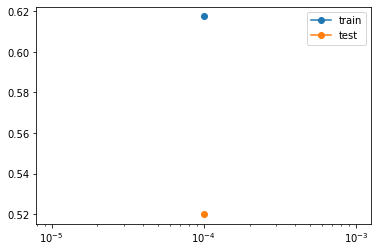

In [58]:

plt.semilogx(values, all_train, label='train', marker='o')
plt.semilogx(values, all_test, label='test', marker='o')
plt.legend()
plt.show()

In [59]:
#print(model.summary())

In [60]:
# Lets look at the model's prediction before training it
#pred = model(X_train)
#print(pred.shape)
#plt.plot(pred)

In [61]:
# here you compile the model and choose the optimizer and loss for the training
#opt = SGD(learning_rate=0.01, momentum=0.9)


In [62]:
from tensorflow.keras.callbacks import EarlyStopping



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


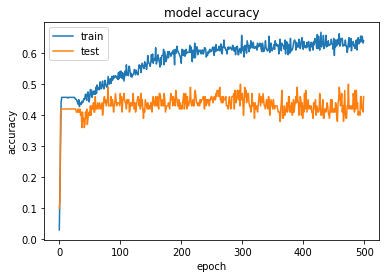

In [72]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

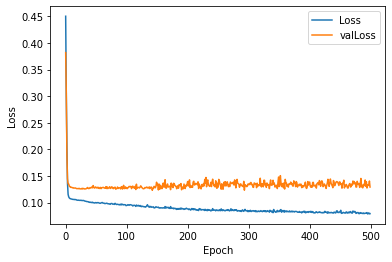

In [73]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='valLoss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<p> Generate Greens function by adding small error to DMFT calculted Greens fn<p>

In [ ]:
def randomgrin(n):
    import random
    sin=np.zeros((500,256*3))
    np.random.seed(n)
    for i in range (500):
        sin[i,:]=np.random.normal(0.5,0.1)
    sin=sin/(np.amax(sin)*100)
    return sin

In [ ]:
Ginp_up_s1=Ginp_up+randomgrin(1)
Ginp_up_s2=Ginp_up+randomgrin(2)
Ginp_up_s3=Ginp_up+randomgrin(3)

In [ ]:
def randomgrout(n):
    import random
    sout=np.zeros((500,256))
    np.random.seed(n)
    for i in range (500):
        sout[i,:]=np.random.normal(0.5,0.1)
    sout=sout/(np.amax(sout)*100)
    return sout

In [ ]:
Gout_up_s1=Gout_up+randomgrout(1)
Gout_up_s2=Gout_up+randomgrout(2)
Gout_up_s3=Gout_up+randomgrout(3)


plt.plot(Gout_up_s1[0,:],'o')
plt.plot(Gout_up_s2[0,:],'o')
plt.plot(Gout_up[0,:],'o')
plt.ylim([0,0.1])

In [ ]:
X=np.vstack((Ginp_up,Ginp_up_s1,Ginp_up_s2,Ginp_up_s3))

In [ ]:
y=np.vstack((Gout_up,Gout_up_s1,Gout_up_s2,Gout_up_s3))

In [ ]:
X_train=X[0:1600,:]
X_test=X[1600:2000,:]
y_train=y[0:1600]
y_test=y[1600:2000]
print(X_train.shape)

<h2>Model<h2>

In [ ]:
from keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l2
# define the Neural Network
model = Sequential()
model.add(Dense(128, activation = 'relu',input_shape=(256*3,))) 
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256))

In [ ]:
print(model.summary())

In [ ]:
# Lets look at the model's prediction before training it
pred = model(X_train)
print(pred.shape)
#plt.plot(pred)

In [ ]:
# here you compile the model and choose the optimizer and loss for the training
#opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(
   loss = 'mse', 
   optimizer = RMSprop(), 
   metrics = ['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
   X_train, y_train,    
   batch_size=10, 
   epochs = 2000, 
   verbose = 1, 
   validation_data=(X_test,y_test), 
   #callbacks = [EarlyStopping(monitor = 'val_loss', patience = 20)]
)

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print("%s: %.4f%%" % (model.metrics_names[1], score[1]*100))

In [ ]:
prediction = model.predict(X_test) 
print(prediction.shape) 
ypred=prediction
print(ypred.shape)
#for i in range(0,80):
#    plt.plot(ypred[i,:],'-')
    
#   print(ypred[i,-1],ypred[i,0])
i=18
#for i in range(10):
#plt.plot(prediction.flatten())
plt.plot(y_test[i,:],'o')
#for i in range(20):
plt.plot(ypred[i,:],'-')
plt.legend(['test', 'pred'], loc='upper right')

#print(ypred[i,-1],ypred[i,0])
#print(y_test[i,-1],y_test[i,0])
#plt.plot(ypred.flatten(),'o')
#plt.plot(y_test.flatten(),'*')
plt.show()


In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='valLoss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()